In [ ]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import Input
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.layers import GlobalAveragePooling2D
from collections import Counter
import librosa.display
import os
from IPython.display import Audio
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# MULTICLASS MODEL

* Goal: Build a neural network to classify between all 12 bird species.
* Preprocessing Approach:

### LOAD DATA

In [ ]:
f = h5py.File('bird_spectrograms.hdf5', 'r')

### PREPROCESSING FOR MULTI CLASS


In [ ]:
all_species = list(f.keys())

# Padd the ...
def pad_spectrogram(spec, target_width=128):
    current_width = spec.shape[1]
    if current_width >= target_width:
        return spec[:, :target_width]
    else:
        pad_width = target_width - current_width
        return np.pad(spec, ((0, 0), (0, pad_width)), mode='constant')

target_width = 128

x_multi = []
y_multi = []

threshold = 0.01
for label in all_species:
    data = np.array(f[label])
    for spec in data:
        padded = pad_spectrogram(spec, target_width=128)
        x_multi.append(padded)
        y_multi.append(label)

print(f"Total kept samples: {len(x_multi)}")
print("Label counts:", dict(zip(*np.unique(y_multi, return_counts=True))) if y_multi else "No labels")



Total kept samples: 1536
Label counts: {np.str_('amecro'): np.int64(128), np.str_('amerob'): np.int64(128), np.str_('bewwre'): np.int64(128), np.str_('bkcchi'): np.int64(128), np.str_('daejun'): np.int64(128), np.str_('houfin'): np.int64(128), np.str_('houspa'): np.int64(128), np.str_('norfli'): np.int64(128), np.str_('rewbla'): np.int64(128), np.str_('sonspa'): np.int64(128), np.str_('spotow'): np.int64(128), np.str_('whcspa'): np.int64(128)}


In [ ]:
# Turn to an array and add channel dimension
x_multi = np.array(x_multi)
x_multi = x_multi[..., np.newaxis]
print("x_multi shape:", x_multi.shape)

x_multi shape: (1536, 517, 128, 1)


In [ ]:
# Per-sample min-max normalization with blank handling
for i in range(x_multi.shape[0]):
    spec = x_multi[i]
    min_val = np.min(spec)
    max_val = np.max(spec)
    if max_val > min_val:
        x_multi[i] = (spec - min_val) / (max_val - min_val)
    else:
        x_multi[i] = 0

print("Mean:", np.mean(x_multi), "Std:", np.std(x_multi))

Mean: 0.5368275702762535 Std: 0.3030183453112897


This is good

In [ ]:
multi_label = LabelEncoder()
y_multi_encoded = multi_label.fit_transform(y_multi)

print("Label mapping:", dict(zip(multi_label.classes_, multi_label.transform(multi_label.classes_))))


Label mapping: {np.str_('amecro'): np.int64(0), np.str_('amerob'): np.int64(1), np.str_('bewwre'): np.int64(2), np.str_('bkcchi'): np.int64(3), np.str_('daejun'): np.int64(4), np.str_('houfin'): np.int64(5), np.str_('houspa'): np.int64(6), np.str_('norfli'): np.int64(7), np.str_('rewbla'): np.int64(8), np.str_('sonspa'): np.int64(9), np.str_('spotow'): np.int64(10), np.str_('whcspa'): np.int64(11)}


In [ ]:
# One hot encode the labels
y_multi_categorical = to_categorical(y_multi_encoded, num_classes=len(all_species))


print("y_multi_categorical shape:", y_multi_categorical.shape)

indices = np.random.choice(len(y_multi_categorical), size=5, replace=False)
for i in indices:
    class_idx = np.argmax(y_multi_categorical[i])
    class_name = multi_label.inverse_transform([class_idx])[0]
    print(f"Sample {i}: class = {class_name}, one-hot = {y_multi_categorical[i]}")


y_multi_categorical shape: (1536, 12)
Sample 1424: class = whcspa, one-hot = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Sample 1261: class = sonspa, one-hot = [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Sample 407: class = bkcchi, one-hot = [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Sample 1137: class = rewbla, one-hot = [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Sample 648: class = houfin, one-hot = [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [ ]:
for idx, name in enumerate(multi_label.classes_):
    print(f"{idx}: {name}")

0: amecro
1: amerob
2: bewwre
3: bkcchi
4: daejun
5: houfin
6: houspa
7: norfli
8: rewbla
9: sonspa
10: spotow
11: whcspa


In [ ]:
# 3-way split: 60% train, 20% val, 20% test
# First 80/40 train test split
X_train_temp, X_test_multi, y_train_temp, y_test_multi = train_test_split(x_multi, y_multi_categorical, test_size=0.2, stratify=y_multi_encoded, random_state=42)

#Second 60/20 train validation split
X_train_multi, X_val_multi, y_train_multi, y_val_multi = train_test_split(X_train_temp, y_train_temp, test_size=0.25, stratify=np.argmax(y_train_temp, axis=1), random_state=42)

y_train_labels = np.argmax(y_train_multi, axis=1)
y_val_labels   = np.argmax(y_val_multi, axis=1)
y_test_labels  = np.argmax(y_test_multi, axis=1)
print("Train label distribution:", Counter(y_train_labels))
print("Val label distribution:", Counter(y_val_labels))
print("Test label distribution:", Counter(y_test_labels))

Train label distribution: Counter({np.int64(9): 77, np.int64(1): 77, np.int64(6): 77, np.int64(2): 77, np.int64(8): 77, np.int64(3): 77, np.int64(0): 77, np.int64(11): 77, np.int64(10): 77, np.int64(4): 76, np.int64(5): 76, np.int64(7): 76})
Val label distribution: Counter({np.int64(7): 26, np.int64(9): 26, np.int64(8): 26, np.int64(5): 26, np.int64(10): 26, np.int64(0): 26, np.int64(4): 26, np.int64(3): 25, np.int64(11): 25, np.int64(2): 25, np.int64(6): 25, np.int64(1): 25})
Test label distribution: Counter({np.int64(3): 26, np.int64(11): 26, np.int64(5): 26, np.int64(1): 26, np.int64(7): 26, np.int64(2): 26, np.int64(4): 26, np.int64(6): 26, np.int64(9): 25, np.int64(0): 25, np.int64(10): 25, np.int64(8): 25})


Preprocessing looks good so we can move on to building and training our neural network

### BUILDING THE MULTI CLASS NEURAL NETWORK - ITERATION 1

In [ ]:
model_multi = Sequential([
    Input(shape=(517, 128, 1)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    GlobalAveragePooling2D(), # Used this instead of flatted to reduce overfitting
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(12, activation='softmax')  # used 12 because i am trying to predict 12 different classes
])


In [ ]:
model_multi.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [ ]:
model_multi.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 517, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 258, 64, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 258, 64, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 129, 32, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 129, 32, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,708 (397.30 KB)

 Trainable params: 101,708 (397.30 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_multi = model_multi.fit(
    X_train_multi, y_train_multi,
    epochs=15,
    batch_size=32,
    validation_data=(X_val_multi, y_val_multi),
    callbacks=[callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

Epoch 1/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 158s 5s/step - accuracy: 0.1169 - loss: 2.4625 - val_accuracy: 0.1759 - val_loss: 2.1820
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 140s 5s/step - accuracy: 0.2390 - loss: 2.0529 - val_accuracy: 0.3648 - val_loss: 1.6734
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 165s 6s/step - accuracy: 0.2521 - loss: 1.8298 - val_accuracy: 0.4104 - val_loss: 1.5531
Epoch 4/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 154s 5s/step - accuracy: 0.3043 - loss: 1.7218 - val_accuracy: 0.3029 - val_loss: 1.4935
Epoch 5/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 201s 5s/step - accuracy: 0.3284 - loss: 1.6253 - val_accuracy: 0.4202 - val_loss: 1.3848
Epoch 6/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 192s 5s/step - accuracy: 0.3589 - loss: 1.5342 - val_accuracy: 0.4625 - val_loss: 1.3346
Epoch 7/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 203s 5s/step - accuracy: 0.4413 - loss: 1.4522 - val_accuracy: 0.5342 - val_loss: 1.2302
Epoch 8/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 146s 5s/step - accuracy: 0.4188 - loss: 1.4127 - val_accuracy: 0.4463 - v

This one started off slow. And accuracy was around 10% at first, which makes sense with 12 classes. But it picked up fast. By the middle, validation accuracy was almost at 50%, and by the end, it hit over 76%, with training accuracy around 65%. Loss kept dropping too, so the model was clearly learning. It didn’t overfit and generalization looked good.

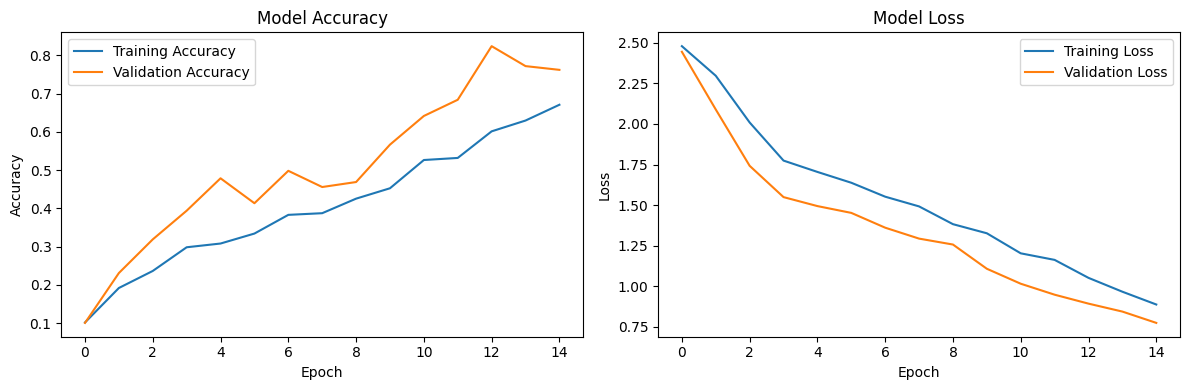

In [ ]:
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_multi.history['accuracy'], label='Training Accuracy')
plt.plot(history_multi.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_multi.history['loss'], label='Training Loss')
plt.plot(history_multi.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

My Model is learning!!!

### BUILDING THE MULTI CLASS NEURAL NETWORK - ITERATION 2

I want to increase the number of epochs to see if this would give me higher accuracy. However, to tackle overfitting I will implement drop out regularization.
Tuning:
* I will increase epoch from 15 to 30
* I will add drop out regulaization

In [ ]:
model_multi2 = Sequential([
    Input(shape=(517, 128, 1)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    GlobalAveragePooling2D(), # Used this instead of flatted to reduce overfitting
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(12, activation='softmax')  # used 12 because i am trying to predict 12 different classes
])


In [ ]:
model_multi2.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [ ]:
model_multi2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 517, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 258, 64, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 258, 64, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 129, 32, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 129, 32, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,708 (397.30 KB)

 Trainable params: 101,708 (397.30 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_multi2 = model_multi2.fit(
    X_train_multi, y_train_multi,
    epochs=30,
    batch_size=32,
    validation_data=(X_val_multi, y_val_multi),
    callbacks=[callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 151s 5s/step - accuracy: 0.1038 - loss: 2.4712 - val_accuracy: 0.1792 - val_loss: 2.2896
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 204s 5s/step - accuracy: 0.2229 - loss: 2.1720 - val_accuracy: 0.2541 - val_loss: 1.8062
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 201s 5s/step - accuracy: 0.2029 - loss: 1.9257 - val_accuracy: 0.4691 - val_loss: 1.6579
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 209s 5s/step - accuracy: 0.2774 - loss: 1.7861 - val_accuracy: 0.4658 - val_loss: 1.5584
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 144s 5s/step - accuracy: 0.3311 - loss: 1.7302 - val_accuracy: 0.4528 - val_loss: 1.4535
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 201s 5s/step - accuracy: 0.3467 - loss: 1.6261 - val_accuracy: 0.4593 - val_loss: 1.4032
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 215s 5s/step - accuracy: 0.4004 - loss: 1.5319 - val_accuracy: 0.4756 - val_loss: 1.3595
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 196s 5s/step - accuracy: 0.3822 - loss: 1.5455 - val_accuracy: 0.6319 - v

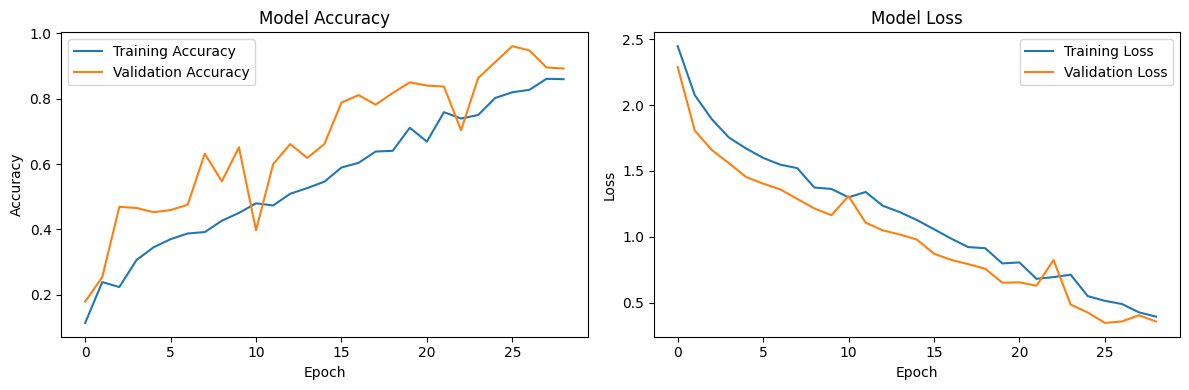

In [ ]:
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_multi2.history['accuracy'], label='Training Accuracy')
plt.plot(history_multi2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_multi2.history['loss'], label='Training Loss')
plt.plot(history_multi2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

This model started slow again, but by mid-training it really started improving. Accuracy gradually climbed and validation accuracy crossed 91% by epoch 25, with the best performance hitting 96%. The loss dropped steadily too, especially in the second half. The only downside is that it took so long to train-about 30 minutes if not more. But that's because I trained on the whole dataset. At the end, this was a big improvement.


# External Test Data

## PREPROCESSING MP3 CLIPS

In [ ]:
mystery_clips = ["/content/test1.mp3", "/content/test2.mp3", "/content/test3.mp3" ]
results = []

In [ ]:
import librosa
import numpy as np

def preprocess_mp3_for_prediction(filepath, target_shape=(517, 128)):
    y, sr = librosa.load(filepath, sr=22050)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=target_shape[0])
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Pad or trim to target time width
    if mel_spec_db.shape[1] < target_shape[1]:
        pad_width = target_shape[1] - mel_spec_db.shape[1]
        mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_spec_db = mel_spec_db[:, :target_shape[1]]

    # Normalize per-sample
    min_val = np.min(mel_spec_db)
    max_val = np.max(mel_spec_db)
    if max_val > min_val:
        mel_spec_norm = (mel_spec_db - min_val) / (max_val - min_val)
    else:
        mel_spec_norm = np.zeros_like(mel_spec_db)

    # Reshape for model input: (1, 517, 128, 1)
    S_input = mel_spec_norm[np.newaxis, ..., np.newaxis]
    return S_input, mel_spec_db


### TRAINING MODEL FOR TESTING

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Playing: test1.mp3


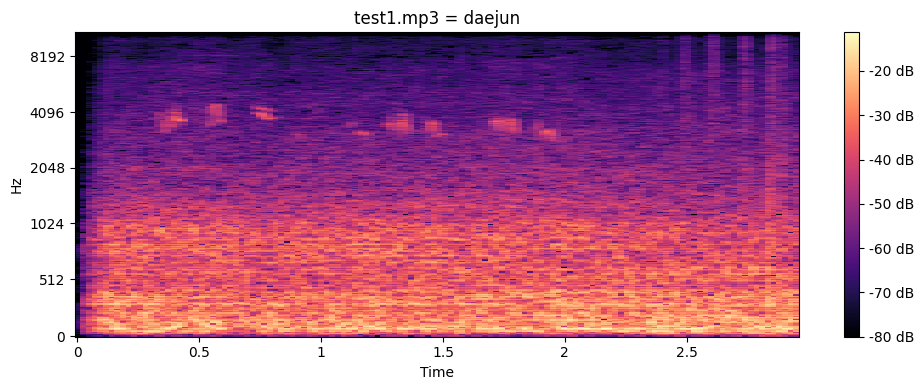

Prediction probabilities for test1.mp3:
  amecro: 0.0039
  amerob: 0.2185
  bewwre: 0.0476
  bkcchi: 0.0032
  daejun: 0.4788
  houfin: 0.0852
  houspa: 0.0046
  norfli: 0.0006
  rewbla: 0.0084
  sonspa: 0.0040
  spotow: 0.0513
  whcspa: 0.0938
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Playing: test2.mp3


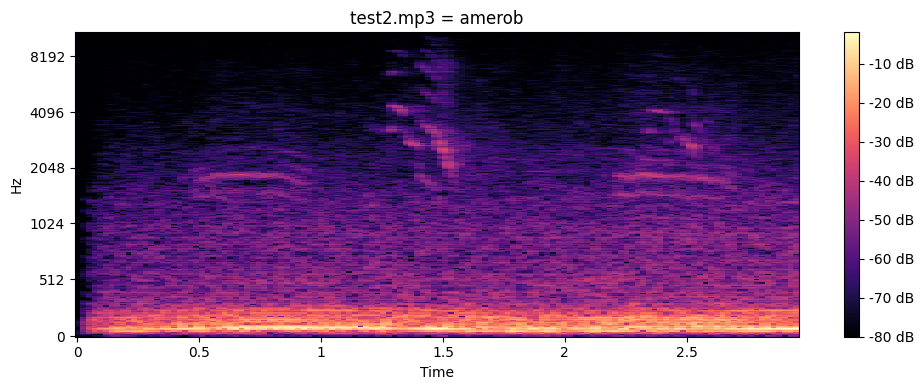

Prediction probabilities for test2.mp3:
  amecro: 0.0000
  amerob: 0.7430
  bewwre: 0.0016
  bkcchi: 0.0000
  daejun: 0.0799
  houfin: 0.0003
  houspa: 0.0091
  norfli: 0.0000
  rewbla: 0.0088
  sonspa: 0.0011
  spotow: 0.1561
  whcspa: 0.0001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Playing: test3.mp3


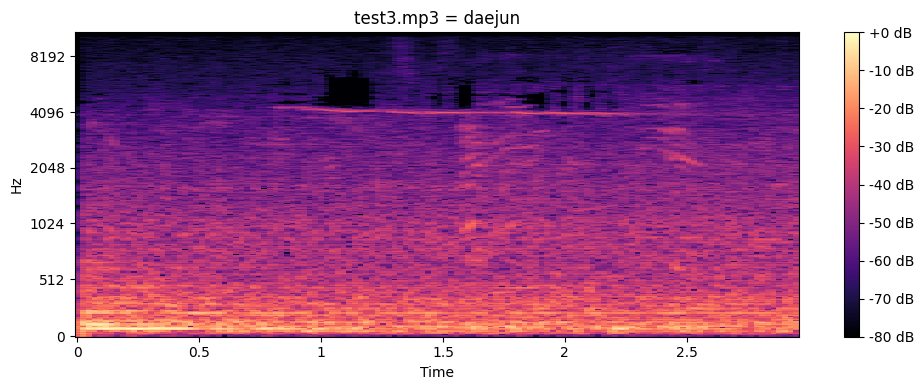

Prediction probabilities for test3.mp3:
  amecro: 0.0010
  amerob: 0.3034
  bewwre: 0.0337
  bkcchi: 0.0017
  daejun: 0.3469
  houfin: 0.0236
  houspa: 0.0160
  norfli: 0.0003
  rewbla: 0.0111
  sonspa: 0.0165
  spotow: 0.2332
  whcspa: 0.0125


In [ ]:
for clip in mystery_clips:
    S_input, S_spec = preprocess_mp3_for_prediction(clip)
    probs = model_multi2.predict(S_input)[0]
    top_idx = np.argmax(probs)
    top_class = multi_label.inverse_transform([top_idx])[0]

    clean_name = os.path.basename(clip)

    print(f"Playing: {clean_name}")
    display(Audio(clip))


    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_spec, sr=22050, x_axis='time', y_axis='mel')
    plt.title(f"{clean_name} = {top_class}")
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

    print(f"Prediction probabilities for {clean_name}:")
    for i, p in enumerate(probs):
        species = multi_label.inverse_transform([i])[0]
        print(f"{species:>8}: {p:.4f}")



    results.append({
        "clip": clip,
        "predicted": top_class,
        "confidence": f"{probs[top_idx]:.2f}",
        "top_3": [
            (multi_label.inverse_transform([i])[0], f"{p:.2f}")
            for i, p in sorted(enumerate(probs), key=lambda x: x[1], reverse=True)[:3]
        ]
    })